## SKOLTECH, Experimental Data Processing

## Evgenii Safronov, Mikhail Kurenkov, Taras Melnik

In [1]:
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from numpy.linalg import inv
import matplotlib as mplb
from matplotlib.font_manager import FontProperties
%matplotlib inline
from numpy.random import normal
from mpl_toolkits.mplot3d import Axes3D
mplb.rc('xtick', labelsize=5) 
mplb.rc('ytick', labelsize=5) 

In [33]:
def kalman_dh(X_0, P_0, z, T, h, R, Q, dh):
    X = np.zeros((len(z),*(X_0.shape)))
    P = np.zeros((len(z),*(P_0.shape)))
    K = np.zeros((len(z), X_0.shape[0], z.shape[1]))
    XF= np.zeros_like(X)
    Xp= np.zeros_like(X)
    for i, _ in enumerate(z):
        #Prediction
        Xp[i] = X[i] = T.dot(X[i-1] if i > 0 else X_0)
        P[i] = T.dot((P[i-1] if i > 0 else P_0).dot(T.transpose())) + Q
        #Filtration
        #tmp1 = inv(H.dot(P[i].dot(H.transpose())) + R[i])
        #tmp2 = H.transpose().dot(tmp1)
        #K[i] = P[i].dot(tmp2)
        tmp1 = inv(dh(Xp[i]).dot(P[i].dot(dh(Xp[i]).transpose())) + R)
        tmp2 = dh(Xp[i]).transpose().dot(tmp1)
        K[i] = P[i].dot(tmp2)
        X[i] = Xp[i] + K[i].dot(z[i] - h(Xp[i]))

        P[i] = (np.identity(X_0.shape[0]) - K[i].dot(dh(Xp[i]))).dot(P[i])
    return X, K, P, Xp

def kalman(X_0, P_0, z, T, H, R, Q):
    X = np.zeros((len(z),*(X_0.shape)))
    P = np.zeros((len(z),*(P_0.shape)))
    K = np.zeros((len(z),*(H.transpose().shape)))
    XF= np.zeros_like(X)
    Xp= np.zeros_like(X)
    T6 = np.linalg.matrix_power(T,6)
    for i, _ in enumerate(z):
        #Prediction
        Xp[i] = X[i] = T.dot(X[i-1] if i > 0 else X_0)
        P[i] = T.dot((P[i-1] if i > 0 else P_0).dot(T.transpose())) + Q
        #Filtration
        tmp1 = inv(H.dot(P[i].dot(H.transpose())) + R)
        tmp2 = H.transpose().dot(tmp1)
        K[i] = P[i].dot(tmp2)
        X[i] = X[i] + K[i].dot(z[i] - H.dot(X[i]))
        P[i] = (np.identity(X_0.shape[0]) - K[i].dot(H)).dot(P[i])
    return X, K, P, Xp

def generate_acc_trajectory(sigma_a_2, sigma_n_2, N, x_0, v_0, t, a_bias = 0):
    if sigma_a_2 == 0:
        a = np.zeros(N) + a_bias
    else:    
        a = np.random.normal(0, sigma_a_2 ** 0.5, N) + a_bias
    v = np.ones(N) * v_0 
    x = np.ones(N) * x_0
    for i, a_i in enumerate(a[:-1]):
        v[i+1] = v[i] + a_i*t
    dx = (v * t + a * t * t / 2)
    for i, dx_i in enumerate(dx[:-1]):
        x[i+1] = x[i] + dx_i
    #v2 = np.ones(N) * v_0 + a.dot(np.triu(np.ones((N, N)), 1)) * t
    #x2 = np.ones(N) * x_0 + (v2 * t + a * t * t / 2).dot(np.triu(np.ones((N, N)), 1))
    z = x + np.random.normal(0, sigma_n_2 ** 0.5, N)
    return x, z

def generate_acc_trajectory_theta(sigma_a_2, sigma_n_2, N, x_0, v_0, t, a_bias = 0, cos_theta = None):
    if sigma_a_2 == 0:
        a = np.zeros(N) + a_bias
    else:    
        a = np.random.normal(0, sigma_a_2 ** 0.5, N) + a_bias
    if cos_theta is None:
        cos_theta = np.ones(N)
    v = np.ones(N) * v_0 * cos_theta
    x = np.ones(N) * x_0
    #for i, a_i in enumerate(a[:-1]):
    #    v[i+1] = v[i] + a_i*t
    dx = (v * t + a * t * t / 2)
    for i, dx_i in enumerate(dx[:-1]):
        x[i+1] = x[i] + dx_i
    #v2 = np.ones(N) * v_0 + a.dot(np.triu(np.ones((N, N)), 1)) * t
    #x2 = np.ones(N) * x_0 + (v2 * t + a * t * t / 2).dot(np.triu(np.ones((N, N)), 1))
    z = x + np.random.normal(0, sigma_n_2 ** 0.5, N)
    return x, z

def convert_to_polar(X):
    x = X[:,0,0]
    y = X[:,2,0]
    D = (x**2 + y**2) ** 0.5
    b = np.arctan(x / y)
    return b, D

# Part 1

## Read the ground truth data for angle $\theta$

In [143]:
θ = np.loadtxt('theta.txt')

In [144]:
print(θ.shape[0])

500


## Generate a true trajectory
## and measurements

In [145]:
N = θ.shape[0] 
t = 0.05
x_0 = 0
y_0 = 0
sigma_a_2 = 1 ** 2
sigma_n_2 = 3 ** 2
V = 10
z = np.zeros((N, 2, 1))
x, z[:,0,0] = generate_acc_trajectory_theta(sigma_a_2, sigma_n_2, N, x_0, V, t, 0, np.cos(θ))
y, z[:,1,0] = generate_acc_trajectory_theta(sigma_a_2, sigma_n_2, N, y_0, V, t, 0, np.cos(θ))

## Kalman filter matrices and parameteres

In [146]:
X_0 = np.array([[zx[1]],
                [(zx[1]-zx[0])/t],
                [zy[1]],
                [(zy[1]-zy[0])/t]])

Φ = np.array([[1, t, 0, 0],
               [0, 1, 0, 0],
               [0, 0, 1, t],
               [0, 0, 0, 1]])

G = np.array([[t*t/2, 0],
              [t    , 0],
              [0, t*t/2],
              [0,     t]])

Q = G.dot(G.transpose())*sigma_a_2*5

H = np.array([[1, 0, 0, 0],
              [0, 0, 1, 0]])

P_0 = np.eye(4)*10**4

R = np.eye(2)*sigma_n_2

In [147]:
X, _, P, _ = kalman(X_0, P_0, z[2:], Φ, H, R, Q)

## Run 500 times

In [148]:
Repeats = 500
N = 500
ErrorXTrue = np.zeros((N-2,Repeats))
ErrorYTrue = np.zeros((N-2,Repeats))
ErrorXFore = np.zeros((N-2,Repeats))
ErrorYFore = np.zeros((N-2,Repeats))
for i in range(0,Repeats):
    x, z[:,0,0] = generate_acc_trajectory_theta(sigma_a_2, sigma_n_2, N, x_0, V, t, 0, np.cos(θ))
    y, z[:,1,0] = generate_acc_trajectory_theta(sigma_a_2, sigma_n_2, N, y_0, V, t, 0, np.sin(θ))
    X, _, P, Xp = kalman(X_0, P_0, z[2:], Φ, H, R, Q)
    ErrorXTrue[:,i] = (x[2:]-X[:,0,0])**2
    ErrorYTrue[:,i] = (y[2:]-X[:,2,0])**2
    ErrorXFore[:,i] = (x[2:]-Xp[:,0,0])**2
    ErrorYFore[:,i] = (y[2:]-Xp[:,2,0])**2
    if i % 50 == 0:
        print(i)

0
50
100
150
200
250
300
350
400
450


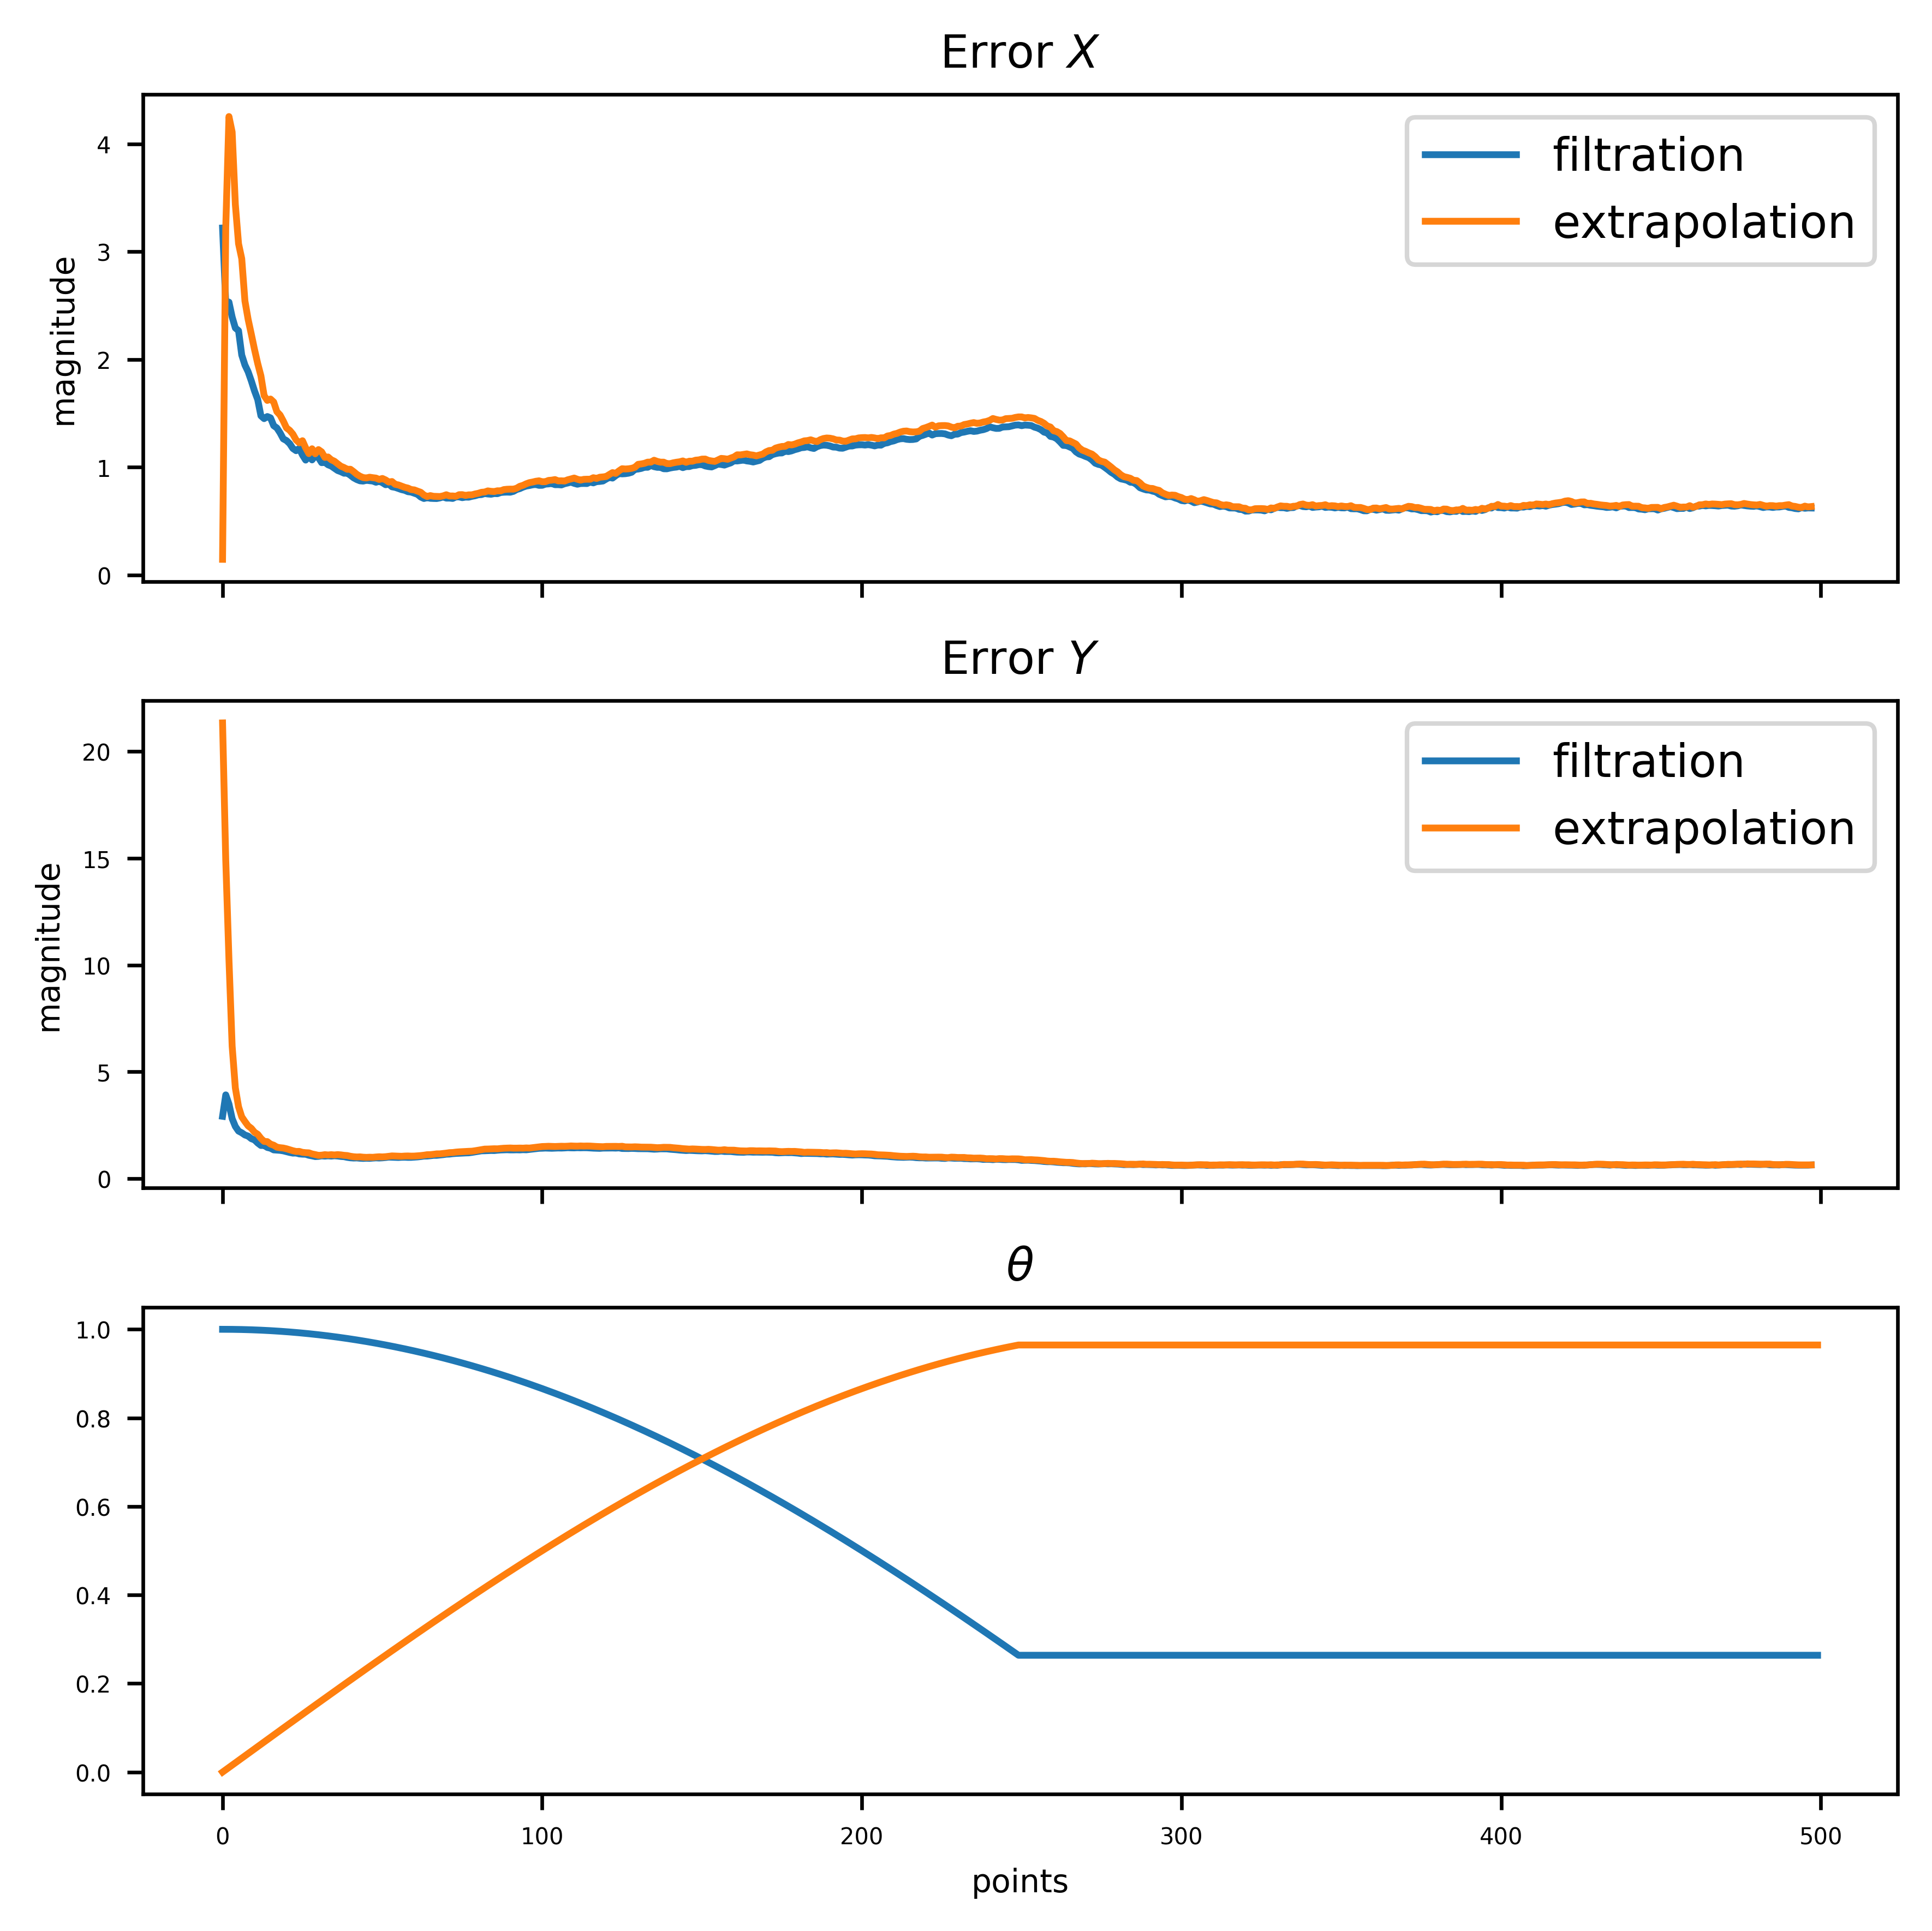

In [149]:
fig, ax = plt.subplots(3,1, figsize=(6,6), dpi = 600, sharex = True)
ax[0].set_title(r'Error $X$', fontsize = 10)
ax[0].plot( (np.sum(ErrorXTrue,axis=1)/(Repeats-1))**0.5, label = 'filtration')
ax[0].plot( (np.sum(ErrorXFore,axis=1)/(Repeats-1))**0.5, label = 'extrapolation')
ax[0].legend(loc='upper right')
ax[0].set_ylabel('magnitude', fontsize = 7)

ax[1].set_title(r'Error $Y$', fontsize = 10)
ax[1].plot( (np.sum(ErrorYTrue,axis=1)/(Repeats-1))**0.5, label = 'filtration')
ax[1].plot( (np.sum(ErrorYFore,axis=1)/(Repeats-1))**0.5,  label = 'extrapolation')
ax[1].legend(loc='upper right')
ax[1].set_ylabel('magnitude', fontsize = 7)
#ax[1].set_ylim(0, 30);

ax[2].set_title(r'$\theta$', fontsize=10)
ax[2].plot(np.cos(θ),label=r'$\cos \theta$')
ax[2].plot(np.sin(θ),label=r'$\sin \theta$')
ax[2].set_xlabel('points', fontsize = 7)
ax[1].legend(loc='best')

plt.tight_layout();

# Part 2

## Generating trajectory
## and measurements

In [150]:
N = θ.shape[0] 
t = 0.05
x_0 = 0
y_0 = 0
sigma_a_2 = 1 ** 2
sigma_n_2 = 3 ** 2
V = 10
z = np.zeros((N, 4, 1))
x, z[:,0,0] = generate_acc_trajectory_theta(sigma_a_2, sigma_n_2, N, x_0, V, t, 0, np.cos(θ))
y, z[:,1,0] = generate_acc_trajectory_theta(sigma_a_2, sigma_n_2, N, y_0, V, t, 0, np.sin(θ))

## Generate measurements of velocity V

In [151]:
sigma_nv_2 =  5
z[:,2,0] = V*np.ones(N) + np.random.normal(0, sigma_nv_2 ** 0.5, N)

## Generate measurements of θ

In [152]:
sigma_nθ_2 = 0.02 ** 2
z[:,3,0] = θ*np.ones(N) + np.random.normal(0, sigma_nθ_2 ** 0.5, N)

## Kalman filter H, dh...

In [153]:
def h(X):
    x = X[0]
    y = X[2]
    H = np.zeros((4, 1))
    H[0] = x
    H[1] = y
    vx = X[1]
    vy = X[3]
    H[2] = (vx ** 2 + vy ** 2) ** 0.5
    H[3] = np.arctan2(vy, vx)
    return H

def dh(X):
    vx = X[1]
    vy = X[3]
    dH = np.zeros((4, 4))
    dH[0, 0] = 1
    dH[1, 2] = 1
    dH[2, 1] = vx / (vx ** 2 + vy ** 2) ** 0.5
    dH[2, 3] = vy / (vx ** 2 + vy ** 2) ** 0.5
    dH[3, 1] = -vy / (vx ** 2 + vy ** 2)
    dH[3, 3] =  vx / (vx ** 2 + vy ** 2)
    return dH

R = np.eye(4) * sigma_n_2
R[2,2] = sigma_nv_2
R[3,3] = sigma_nθ_2

X_0 = np.array([[z[0,1,0]],
                [(z[0,1,0]-z[0,0,0])/t],
                [z[1,1,0]],
                [(z[1,1,0]-z[1,0,0])/t]])

In [154]:
X, K, _, Xp = kalman_dh(X_0, P_0, z, Φ, h, R, Q, dh)

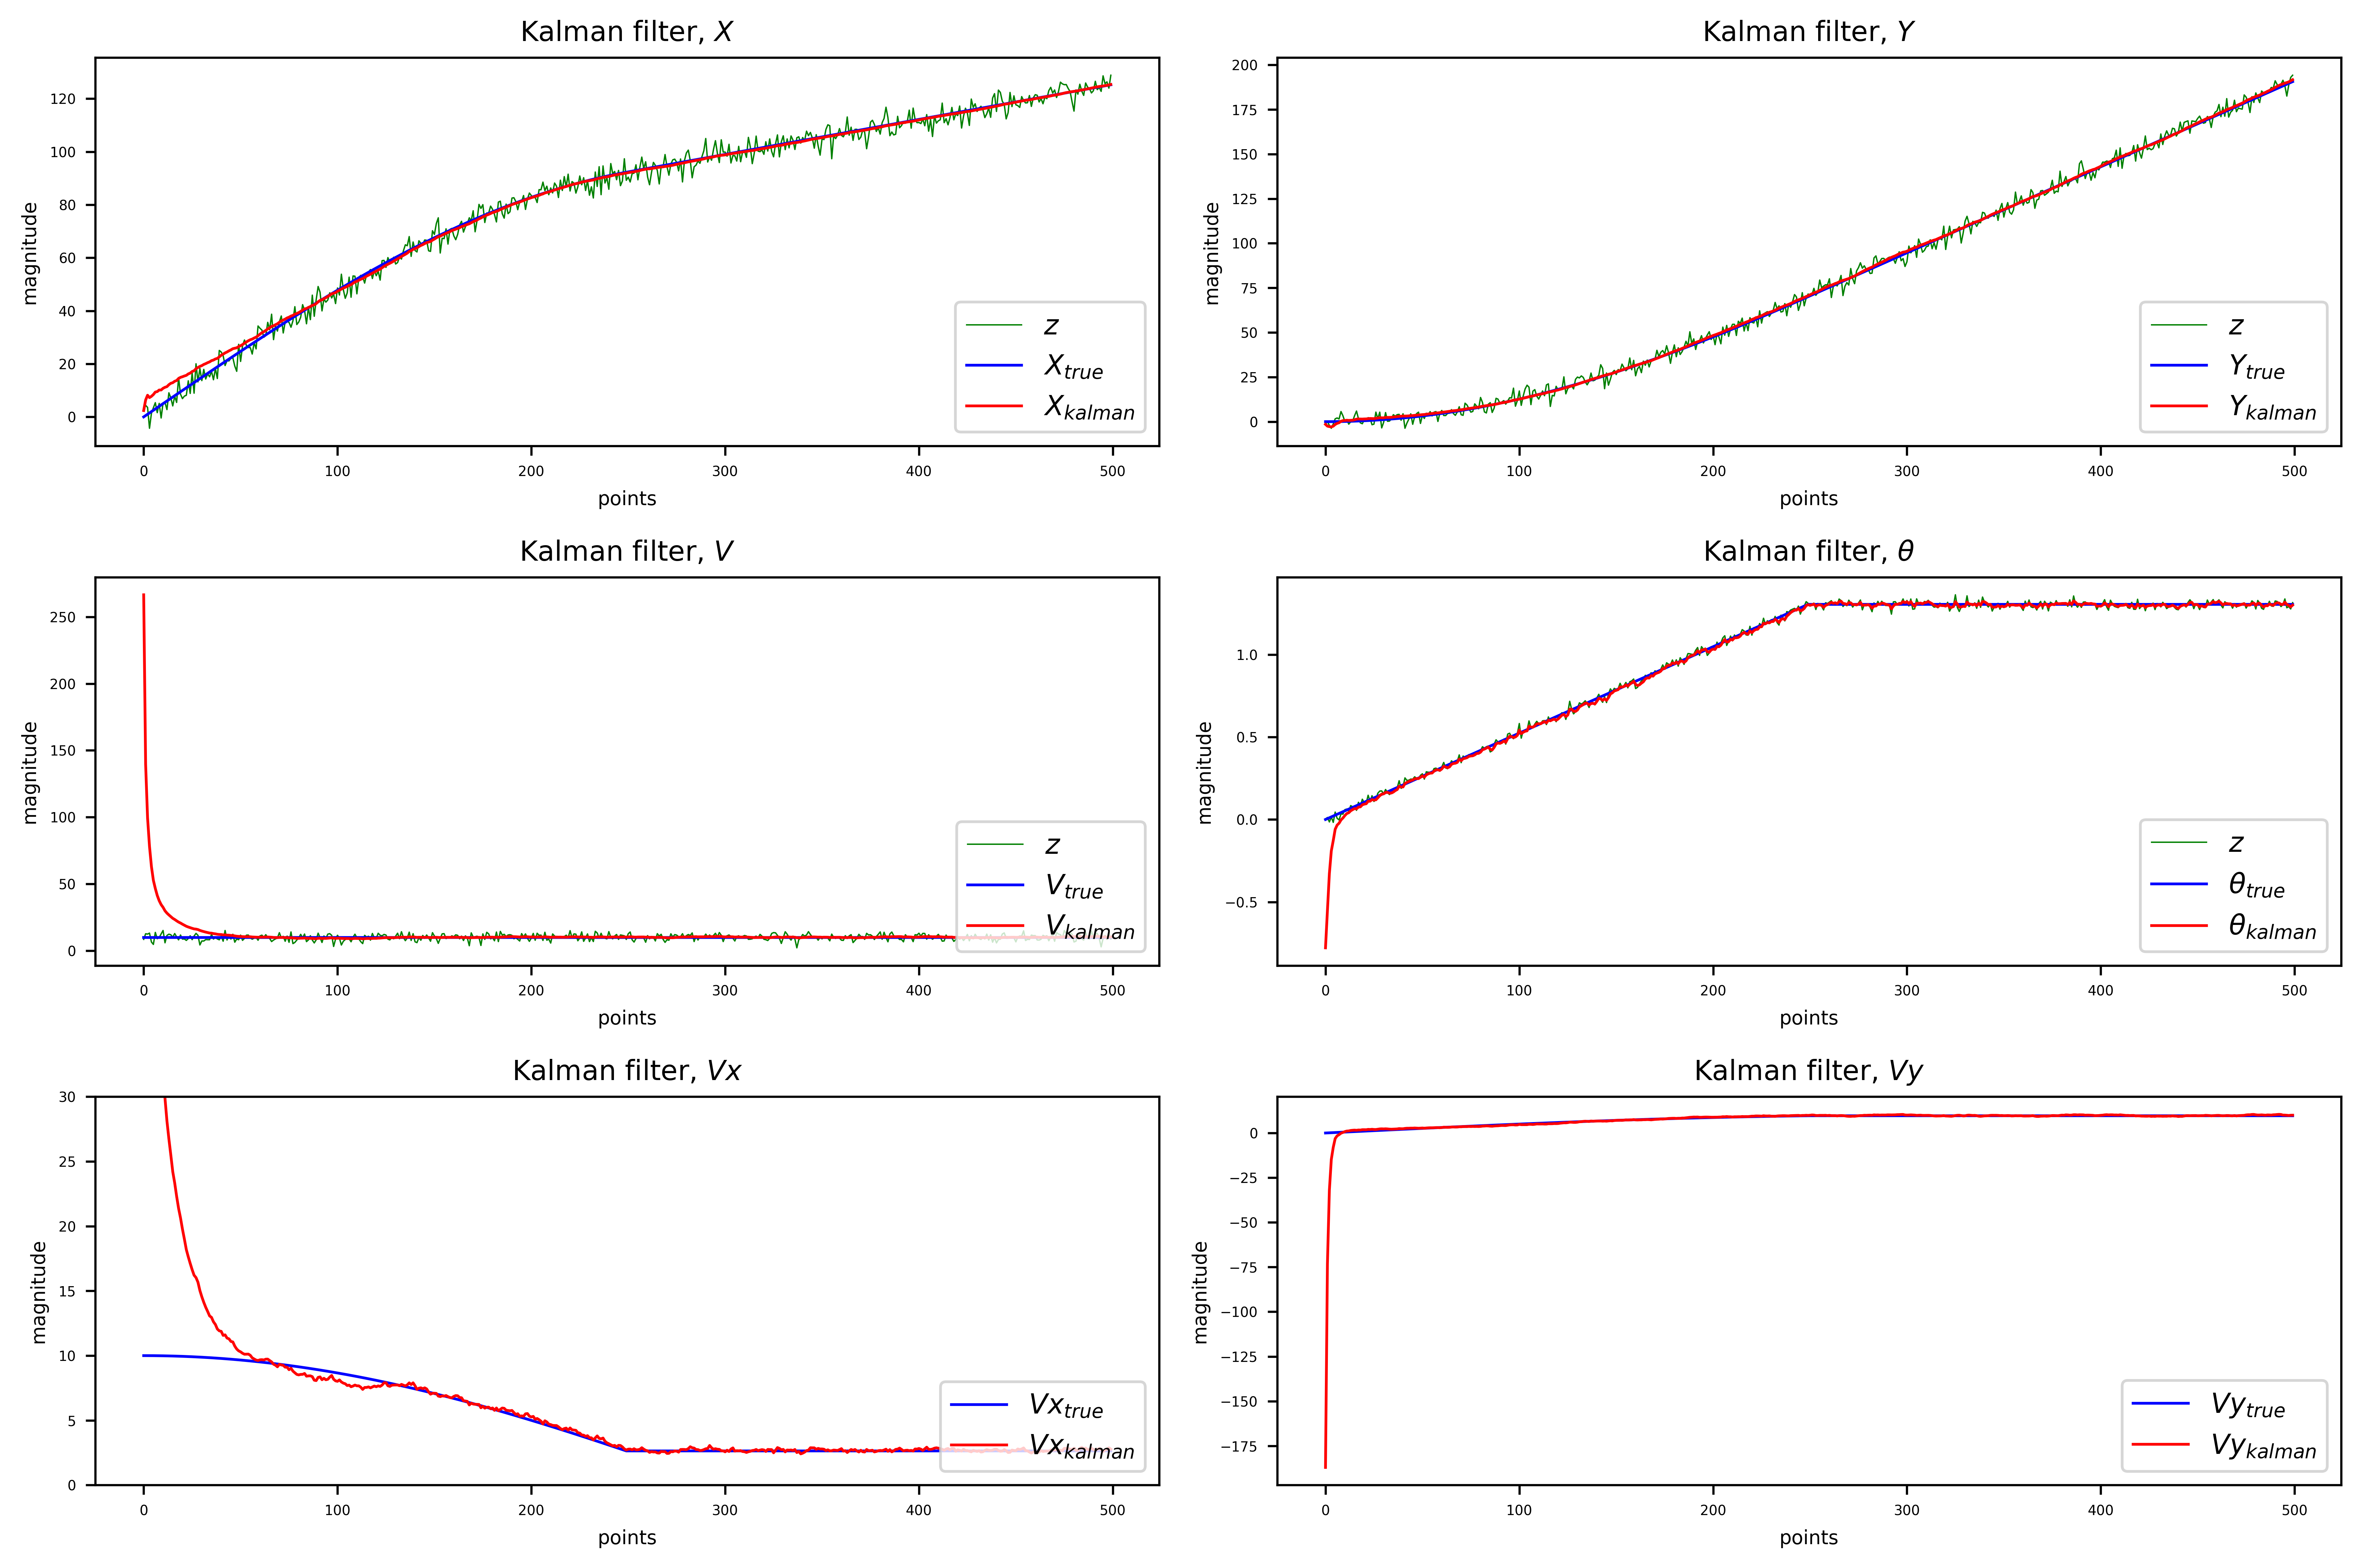

In [155]:
fig, ax = plt.subplots(3,2, figsize=(12,8),dpi=600)
names = ['X','Y','V',r'\theta','Vx','Vy']
xtrue = [x,y,V*np.ones(N),θ, V*np.ones(N)*np.cos(θ), V*np.ones(N)*np.sin(θ)]
XK = [X[:,0],X[:,2],(X[:,1]**2 + X[:,3]**2)**0.5, np.arctan2(X[:,3],X[:,1]), X[:,1], X[:,3]]
for i, name in enumerate(names):
    ax[int(i/2)][i%2].set_title('Kalman filter, $%s$ '%(name), fontsize = 10)
    if i < 4:
        ax[int(i/2)][i%2].plot(range(N),z[:,i],'g', label = '$z$', linewidth = 0.5 )
    ax[int(i/2)][i%2].plot(range(N),xtrue[i],'b', label = '$%s_{true}$'%(name), linewidth = 1 )
    ax[int(i/2)][i%2].plot(range(N),XK[i].transpose()[0],'r', label = '$%s_{kalman}$'%(name), linewidth = 1 )
    #ax.plot(range(N),K[:,0].transpose()[0],'y', label = 'K', linewidth = 1 )
    #ax[0].set_xlim([0,20])
    #ax[0].set_ylim([0,400])
    ax[int(i/2)][i%2].legend(loc='lower right')
    ax[int(i/2)][i%2].set_xlabel('points', fontsize = 7)
    ax[int(i/2)][i%2].set_ylabel('magnitude', fontsize = 7)
ax[2][0].set_ylim([0,30])
plt.tight_layout()

## Run 500 times

In [156]:
Repeats = 500
N = 500
ErrorXTrue = np.zeros((N-2,Repeats))
ErrorYTrue = np.zeros((N-2,Repeats))
ErrorXFore = np.zeros((N-2,Repeats))
ErrorYFore = np.zeros((N-2,Repeats))
for i in range(0,Repeats):
    x, z[:,0,0] = generate_acc_trajectory_theta(sigma_a_2, sigma_n_2, N, x_0, V, t, 0, np.cos(θ))
    y, z[:,1,0] = generate_acc_trajectory_theta(sigma_a_2, sigma_n_2, N, y_0, V, t, 0, np.sin(θ))
    z[:,2,0] = V*np.ones(N) + np.random.normal(0, sigma_nv_2 ** 0.5, N)
    z[:,3,0] = θ*np.ones(N) + np.random.normal(0, sigma_nθ_2 ** 0.5, N)
    X_0 = np.array([[z[0,1,0]],
                [(z[0,1,0]-z[0,0,0])/t],
                [z[1,1,0]],
                [(z[1,1,0]-z[1,0,0])/t]])
    X, K, _, Xp = kalman_dh(X_0, P_0, z[2:], Φ, h, R, Q, dh)
    ErrorXTrue[:,i] = (x[2:]-X[:,0,0])**2
    ErrorYTrue[:,i] = (y[2:]-X[:,2,0])**2
    ErrorXFore[:,i] = (x[2:]-Xp[:,0,0])**2
    ErrorYFore[:,i] = (y[2:]-Xp[:,2,0])**2
    if i % 50 == 0:
        print(i)

0
50
100
150
200
250
300
350
400
450


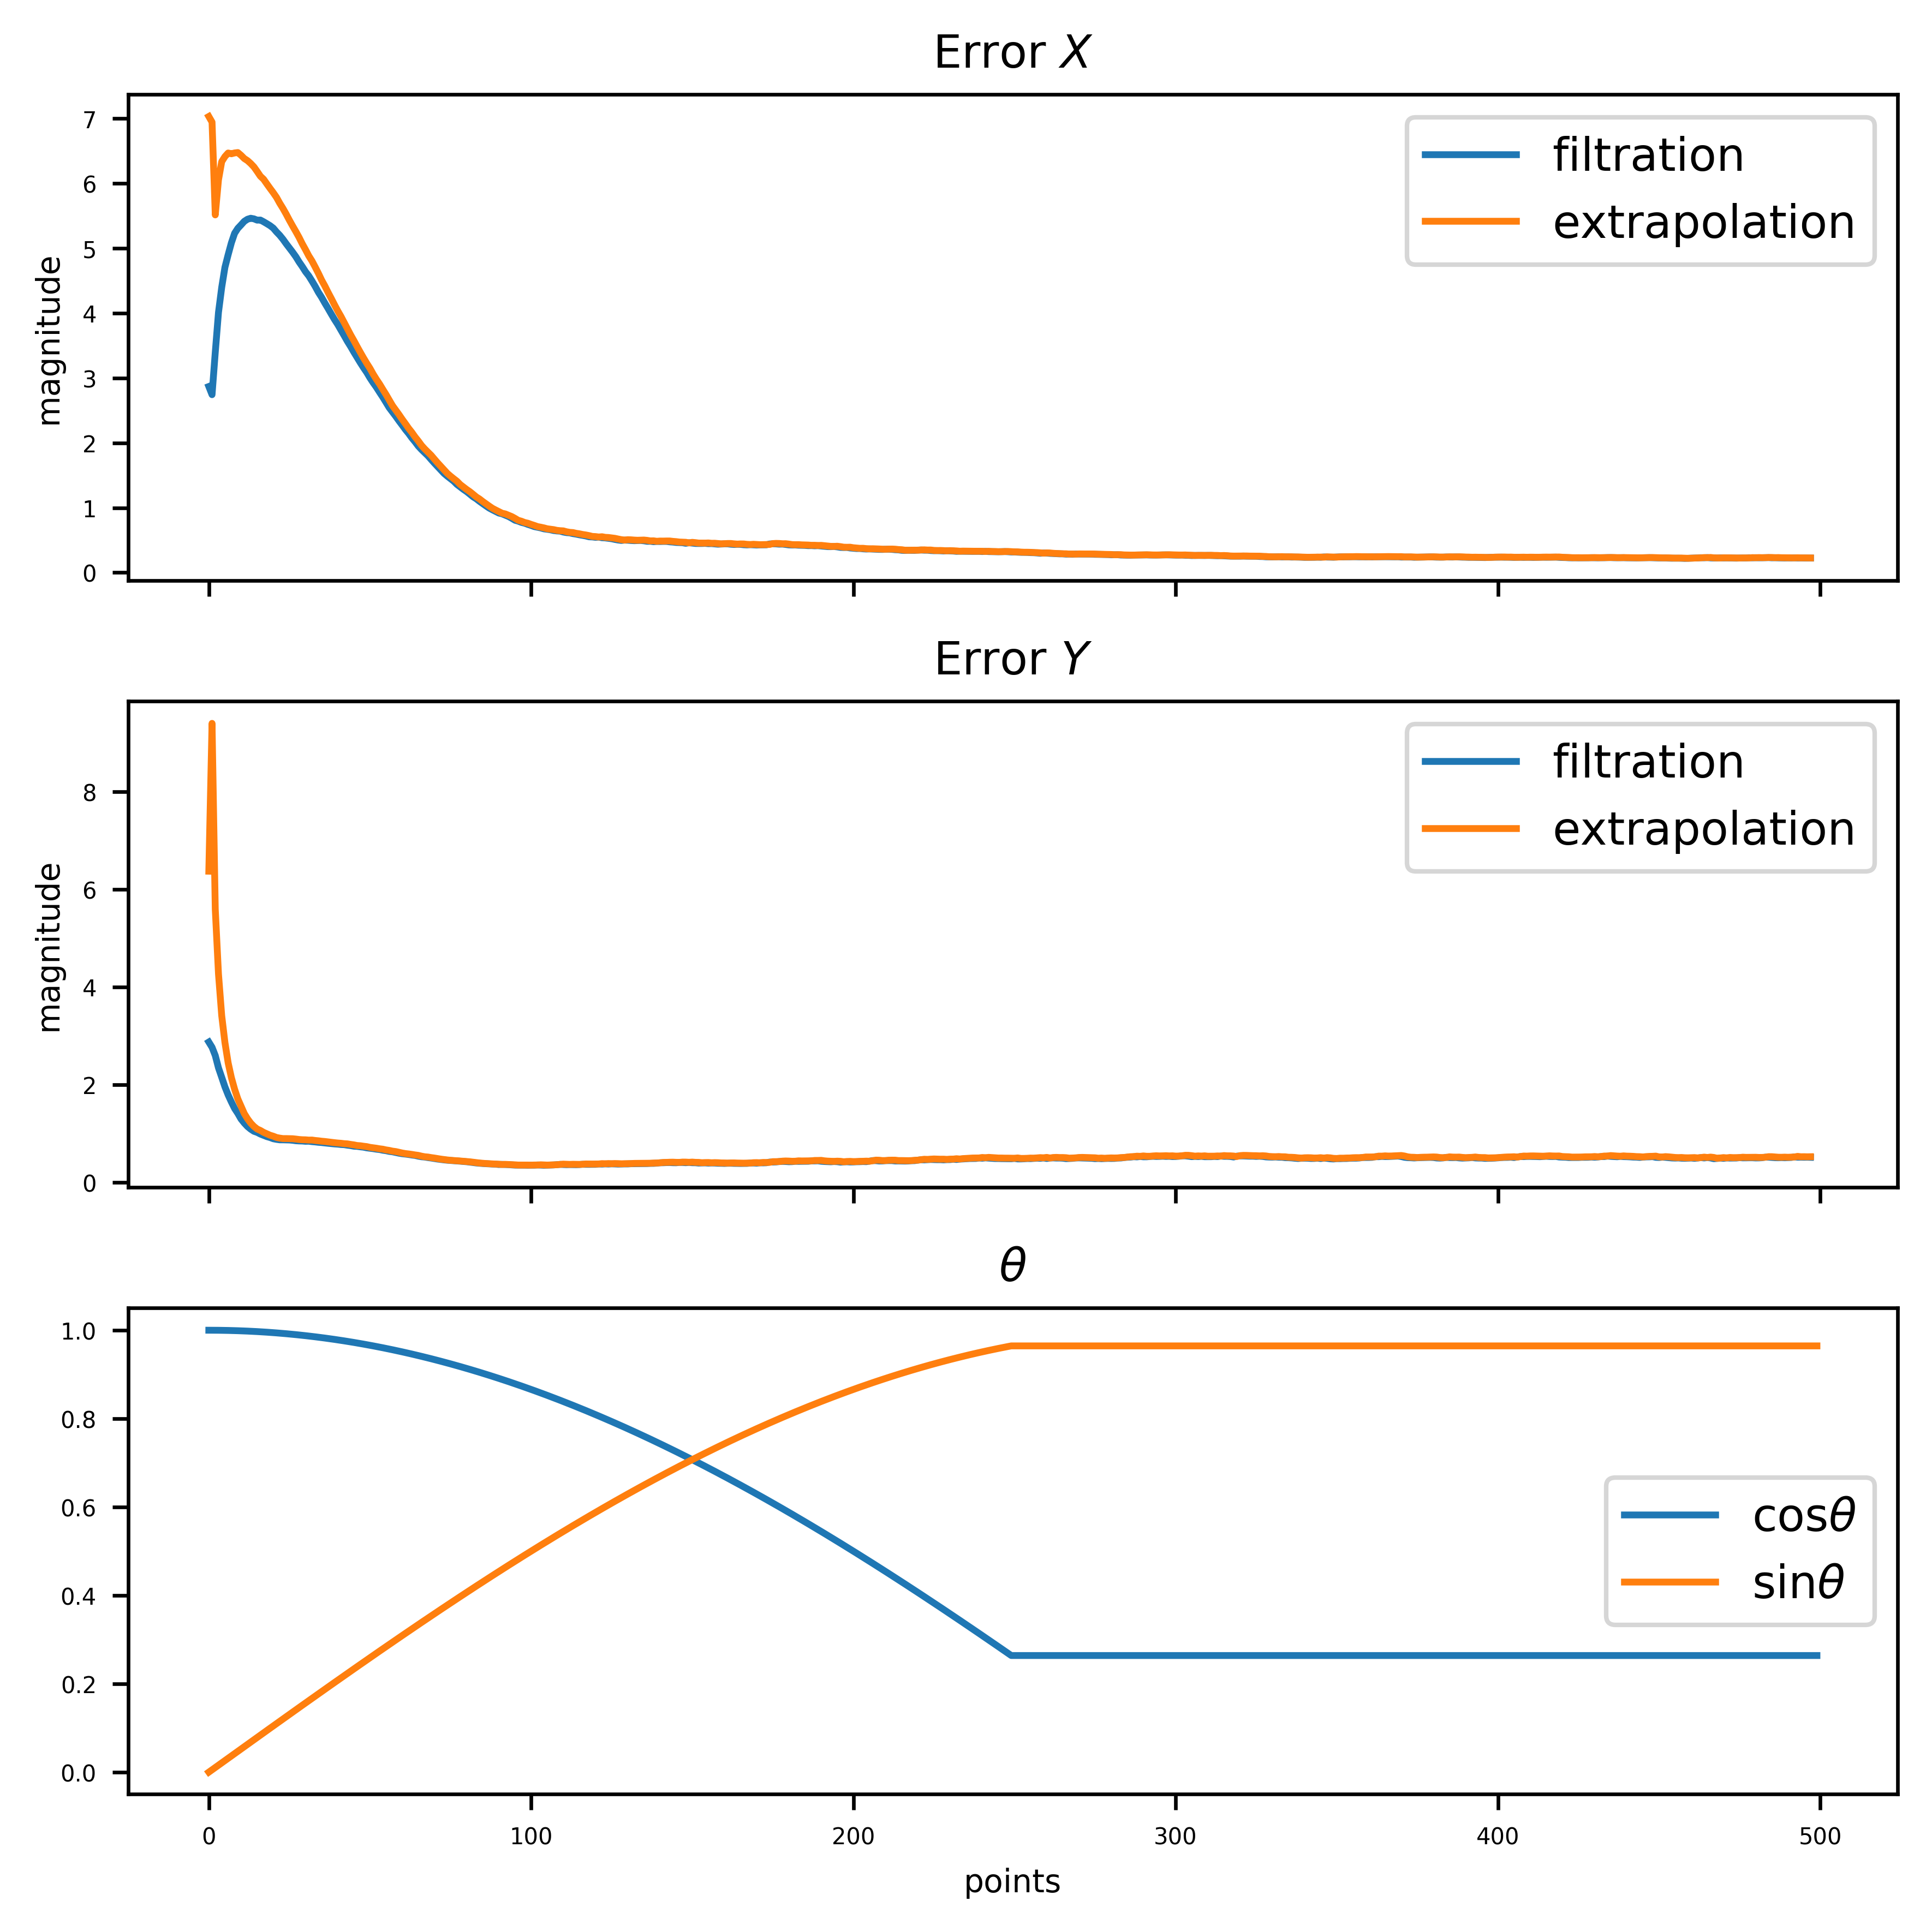

In [157]:
fig, ax = plt.subplots(3,1, figsize=(6,6), dpi = 600, sharex = True)
ax[0].set_title(r'Error $X$', fontsize = 10)
ax[0].plot( (np.sum(ErrorXTrue,axis=1)/(Repeats-1))**0.5, label = 'filtration')
ax[0].plot( (np.sum(ErrorXFore,axis=1)/(Repeats-1))**0.5, label = 'extrapolation')
ax[0].legend(loc='upper right')
ax[0].set_ylabel('magnitude', fontsize = 7)

ax[1].set_title(r'Error $Y$', fontsize = 10)
ax[1].plot( (np.sum(ErrorYTrue,axis=1)/(Repeats-1))**0.5, label = 'filtration')
ax[1].plot( (np.sum(ErrorYFore,axis=1)/(Repeats-1))**0.5,  label = 'extrapolation')
ax[1].legend(loc='upper right')
ax[1].set_ylabel('magnitude', fontsize = 7)
#ax[1].set_ylim(0, 30);

ax[2].set_title(r'$\theta$', fontsize=10)
ax[2].plot(np.cos(θ),label=r'$\cos \theta$')
ax[2].plot(np.sin(θ),label=r'$\sin \theta$')
ax[2].set_xlabel('points', fontsize = 7)
ax[2].legend(loc='best')
plt.tight_layout();

## Estimation accuracy of GPS only is lower than fusion of both GPS and odometry data. Different sources of data reduce the errors.